This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))


['dogs-vs-cats']


In [2]:
print(keras.__version__)

2.4.3


# Define Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 20
num_epochs=5
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
WORK_PATH="/kaggle/working/"
TRAIN_PATH="/kaggle/working/train/"
TEST_PATH="/kaggle/working/test/"

# Prepare Traning Data

In [4]:
filenames = os.listdir("../input/dogs-vs-cats")
print(filenames)

['train.zip', 'test1.zip', 'sampleSubmission.csv']


In [5]:
#압축을 풀어준다.
import zipfile
myzip = zipfile.ZipFile('../input/dogs-vs-cats/train.zip')
myzip.extractall(WORK_PATH)
myzip.close()

In [6]:
# 경로안에 데이터 확인
filenames = os.listdir(TRAIN_PATH)
print(filenames)

['cat.5112.jpg', 'dog.9426.jpg', 'cat.3819.jpg', 'cat.11210.jpg', 'dog.4885.jpg', 'cat.1059.jpg', 'cat.1830.jpg', 'dog.9261.jpg', 'cat.7401.jpg', 'cat.3470.jpg', 'dog.11584.jpg', 'dog.593.jpg', 'dog.4136.jpg', 'cat.3310.jpg', 'cat.311.jpg', 'cat.10099.jpg', 'dog.12064.jpg', 'dog.7427.jpg', 'cat.3471.jpg', 'cat.7392.jpg', 'dog.8838.jpg', 'cat.2042.jpg', 'cat.6793.jpg', 'cat.8236.jpg', 'dog.10664.jpg', 'cat.9668.jpg', 'cat.10288.jpg', 'cat.2297.jpg', 'dog.8240.jpg', 'dog.8100.jpg', 'dog.3320.jpg', 'cat.9534.jpg', 'cat.8379.jpg', 'cat.969.jpg', 'cat.1843.jpg', 'cat.2261.jpg', 'dog.4846.jpg', 'dog.10602.jpg', 'dog.4388.jpg', 'cat.11278.jpg', 'cat.6769.jpg', 'dog.5106.jpg', 'dog.11882.jpg', 'cat.6795.jpg', 'cat.6505.jpg', 'dog.12406.jpg', 'cat.6063.jpg', 'cat.6709.jpg', 'cat.3121.jpg', 'cat.2023.jpg', 'dog.5439.jpg', 'dog.8331.jpg', 'dog.1058.jpg', 'cat.6982.jpg', 'dog.5260.jpg', 'dog.11829.jpg', 'dog.9104.jpg', 'cat.7017.jpg', 'dog.3018.jpg', 'cat.7702.jpg', 'dog.7622.jpg', 'cat.703.jpg', 

In [7]:

categories = []
for filename in filenames:
    # 파일 이름을 '.'을 기준으로 자른다
    # ex) cat.9526.jpg --> ['cat','9526',jpg]
    category = filename.split('.')[0] # [0] --> 'cat'만 return된다
    if category == 'dog': # 카테고리가 dog라면 categories에 1이 append된다
        categories.append(1)
    else:# 카테고리가 dog아니라면 categories에 0이 append된다
        categories.append(0)

In [8]:
# data Frame으로 만들어 준다
# dictionary로 넣어주면 열로 들어가게 된다
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
# df의 앞에 5개 출력해서 data 확인
# 개 = 1, 고양이 = 0으로 출력 되는 것을 확인할 수 있다
df.head()

,filename,category
0,cat.5112.jpg,0
1,dog.9426.jpg,1
2,cat.3819.jpg,0
3,cat.11210.jpg,0
4,dog.4885.jpg,1


In [10]:
# df의 뒤에 5개 출력해서 data 확인
# 개 = 1, 고양이 = 0으로 출력 되는 것을 확인할 수 있다
df.tail()

,filename,category
24995,dog.12007.jpg,1
24996,cat.12123.jpg,0
24997,dog.5655.jpg,1
24998,dog.6213.jpg,1
24999,cat.3330.jpg,0


### See Total In count

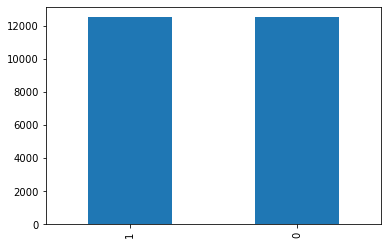

In [11]:
# 카테고리를 중심으로 데이터의 분포가 어떻게 되어있는지 확인
df['category'].value_counts().plot.bar()

![](http://)From our data we have 12500 cats and 12500 dogs

# See sample image

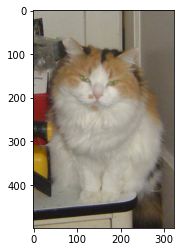

In [12]:
# filenames 안에서 random으로 골라서 이미지 출력
sample = random.choice(filenames)
image = load_img(TRAIN_PATH+sample)
plt.imshow(image)

# Build Model

In [13]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 1.6 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB4

import efficientnet.keras as efn 
n_classes = 2

#efnb3 = efn.EfficientNetB3(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)
# 모델 불러오기
# EfficientNet은 최근 ImageNet 대회에서 가벼운 모델로 최고 성능을 냈다. 
efficentNet = EfficientNetB4(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

71688192/71686520 [==============================] - 1s 0us/step


In [15]:
# efficentNet 정보 확인
efficentNet.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
for layer in efficentNet.layers[:451]:
    layer.trainable = False
#efficentNet.layers 300번 부터 맨 뒤까지 trainable = True로 바꾼다
for layer in efficentNet.layers[450:]:
    layer.trainable = True

In [17]:
# efficentNet의 레이어 갯수 : 474
print(len(efficentNet.layers))

474


In [18]:
# Sequential() : 모델 레이어를 선형으로 구성
model = Sequential()
model.add(efficentNet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# 입력 뉴런과 가중치를 계산한 값을 각 클래스의 확률 개념으로 표현할 수 있는 활성화 함수인 softmax를 사용
# n_classes = 2
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3586      
Total params: 17,677,409
Trainable params: 4,814,870
Non-trainable params: 12,862,539
_________________________________________________________________


In [19]:
#sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
# 옵티마이저
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# validation set 의 loss 를 monitoring, performance measure를 최소화한 후에
# keras 에서 알아서 적절한 epoch 에서 training 을 멈춘다.
# verbose=1 로 지정하면, 언제 keras 에서 training 을 멈추었는지를 화면에 출력할 수 있다.
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)

# Local Minima에 빠져버린 경우, 쉽게 빠져나오지 못하고 갇혀버리게 되는데,
# 이때 learning rate를 늘리거나 줄여주는 방법으로 빠져나오는 효과
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [20]:
# 컴파일 조건
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['acc'])

# Callbacks

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [22]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [25]:
# 0: 'cat', 1: 'dog' 으로 바꾸어 준다
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [26]:
df.head()

,filename,category
0,cat.5112.jpg,cat
1,dog.9426.jpg,dog
2,cat.3819.jpg,cat
3,cat.11210.jpg,cat
4,dog.4885.jpg,dog


In [27]:
# 데이터 나누기 train / validate
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
# train data index 다시 정렬 / 새로운 인덱스를 남기고 원래 인덱스 삭제
train_df = train_df.reset_index(drop=True)
# validate indax 다시 정렬
validate_df = validate_df.reset_index(drop=True)

In [28]:
print(len(train_df))
print(len(validate_df))

20000
5000


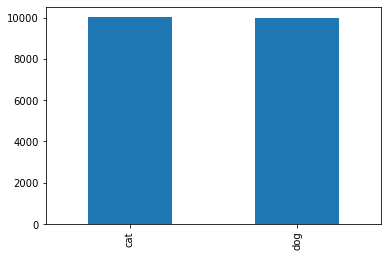

In [29]:
# train 안에 category를 기준으로 갯수를 세어 이미지 출력
train_df['category'].value_counts().plot.bar()

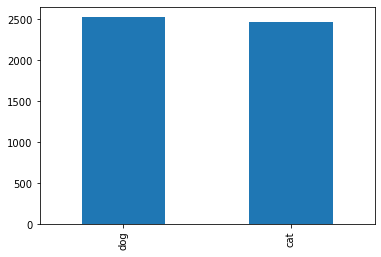

In [30]:
# validate 안에 category를 기준으로 갯수를 세어 이미지 출력
validate_df['category'].value_counts().plot.bar()

In [31]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16


In [32]:
# 데이터의 갯수를 저장하고 있다
print(total_train)
print(total_validate)

20000
5000


# Traning Generator

In [33]:
# data augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# 데이터 프레임에서 불러오는 함수
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # 데이터프레임
    TRAIN_PATH, # 데이터 위치
    x_col='filename', # 파일위치 열이름
    y_col='category', # 클래스 열이름
    target_size=IMAGE_SIZE, # 이미지 사이즈
    class_mode='categorical', # Y값 변화방법
    batch_size=batch_size # 배치사이즈
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [34]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [35]:
# train 데이터 프레임에서 샘플하나를 뽑아와서 generator가 어떻게 일하는지 보여줌
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


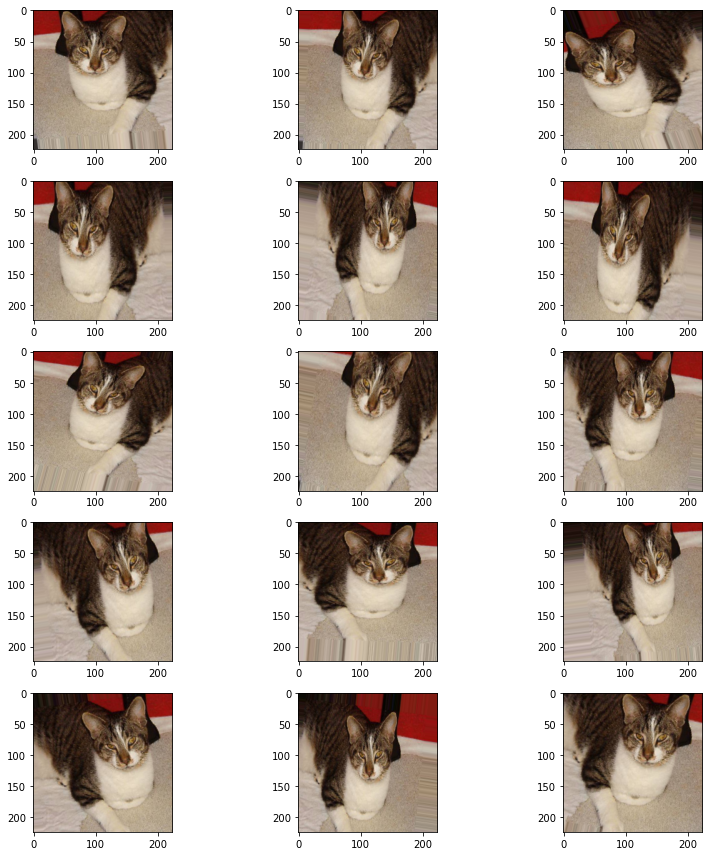

In [36]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

In [37]:
# 학습 시키기
epochs=3 if FAST_RUN else num_epochs
history = model.fit_generator(
    train_generator, 
    epochs=7,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/7
1250/1250 [==============================] - 372s 297ms/step - loss: 0.7017 - acc: 0.5063 - val_loss: 0.6944 - val_acc: 0.5062
Epoch 2/7
1250/1250 [==============================] - 373s 298ms/step - loss: 0.6957 - acc: 0.4974 - val_loss: 0.6957 - val_acc: 0.4942
Epoch 3/7
1250/1250 [==============================] - ETA: 0s - loss: 0.6952 - acc: 0.5042
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 [==============================] - 370s 296ms/step - loss: 0.6952 - acc: 0.5042 - val_loss: 0.6940 - val_acc: 0.5062
Epoch 4/7
1250/1250 [==============================] - 370s 296ms/step - loss: 0.6940 - acc: 0.5042 - val_loss: 0.6930 - val_acc: 0.5058
Epoch 5/7
1250/1250 [==============================] - ETA: 0s - loss: 0.6940 - acc: 0.4992
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1250/1250 [==============================] - 371s 297ms/step - loss: 0.6940 - acc: 0.4992 - val_loss: 0.6934 - val_acc

# Save Model

In [42]:
model.save_weights("model.h5")

# Virtualize Training

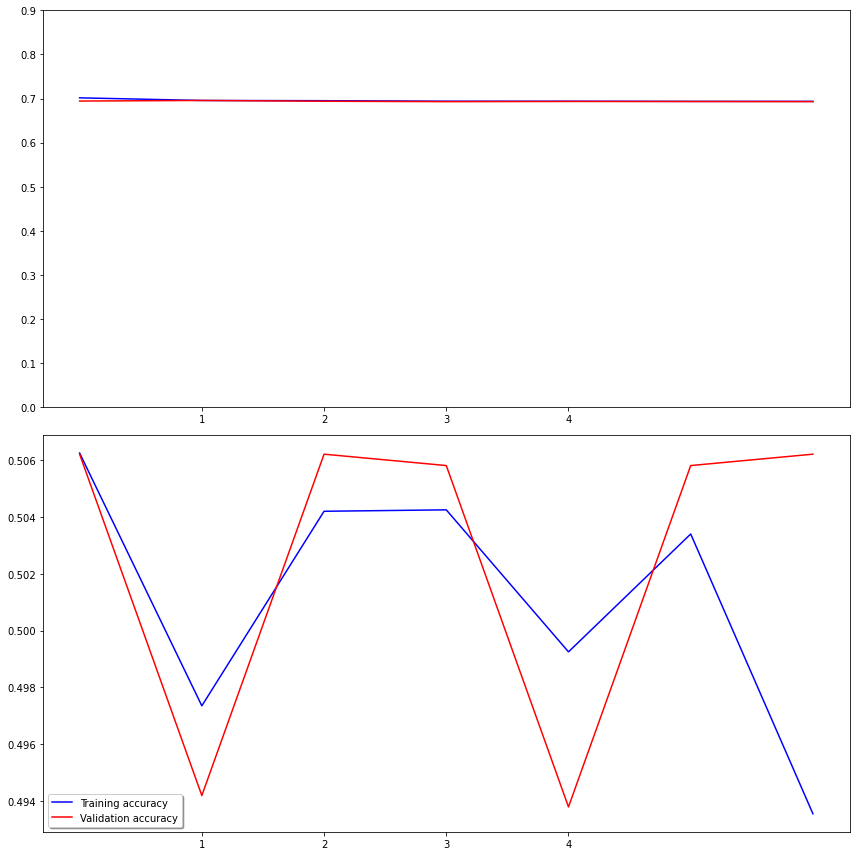

In [39]:
# 결과를 이미지로 출력
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [43]:
#압축을 풀어준다.
import zipfile
myzip = zipfile.ZipFile('../input/dogs-vs-cats/test1.zip')
myzip.extractall('/kaggle/working')
myzip.close()

FileNotFoundError: [Errno 2] No such file or directory: '../input/dogs-vs-cats/test.zip'

In [41]:
TEST_PATH="/kaggle/working/test1/"
import os
test_filenames = os.listdir(TEST_PATH)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/test/'

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# Predict

In [ ]:
# 모델 사용 시에 제네레이터에서 제공되는 샘플을 입력할 때는 predict_generator 함수를 사용
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
# np.argmax : 최대값의 인덱스
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)